In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['plates', '__MACOSX', '__notebook_source__.ipynb']


In [2]:
# ILLUSTRATION OF TRANSFORMS: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
# sphinx_gallery_thumbnail_path = "../../gallery/assets/transforms_thumbnail.png"

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = [16, 16]
# if you change the seed, make sure that the randomly-applied transforms
# properly show that the image can be both transformed and *not* transformed!
torch.manual_seed(0);

def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [3]:
!ls ./plates/train/cleaned

0000.jpg  0003.jpg  0006.jpg  0009.jpg	0012.jpg  0015.jpg  0018.jpg
0001.jpg  0004.jpg  0007.jpg  0010.jpg	0013.jpg  0016.jpg  0019.jpg
0002.jpg  0005.jpg  0008.jpg  0011.jpg	0014.jpg  0017.jpg


In [4]:
!ls ./plates/train/dirty

0000.jpg  0003.jpg  0006.jpg  0009.jpg	0012.jpg  0015.jpg  0018.jpg
0001.jpg  0004.jpg  0007.jpg  0010.jpg	0013.jpg  0016.jpg  0019.jpg
0002.jpg  0005.jpg  0008.jpg  0011.jpg	0014.jpg  0017.jpg


In [23]:
orig_img = Image.open('./plates/train/cleaned/0011.jpg')

(256, 341)


[(262, 347), (276, 361), (316, 401), (356, 441)]

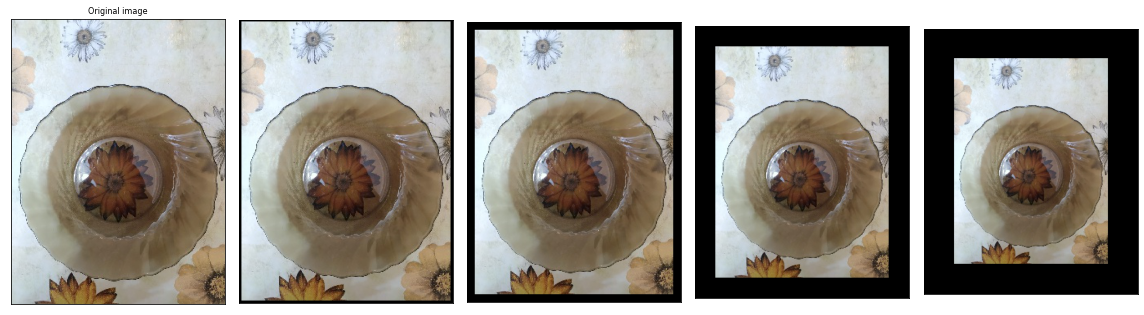

In [6]:
# Pad
# The Pad transform (see also pad()) fills image borders with some pixel values.
padded_imgs = [T.Pad(padding=padding)(orig_img) for padding in (3, 10, 30, 50)]
plot(padded_imgs)
print(orig_img.size)
[img.size for img in padded_imgs]

(256, 341)


[(30, 39), (30, 30), (50, 66), (100, 133), (30, 60), (341, 256)]

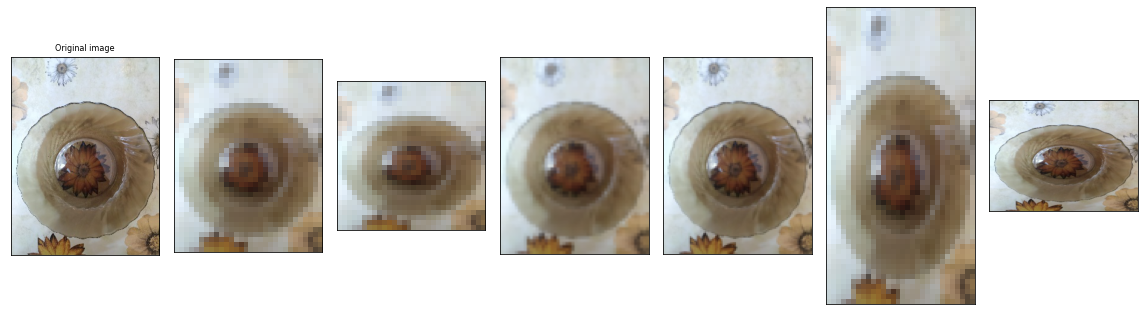

In [7]:
# Resize
# The Resize transform (see also resize()) resizes an image.
# size = (h, w) or (w)

#Делает ресайз изображения:
# - Если size задан одним числом, то он станет шириной (w), итоговый размер будет (size * height/width, size),
#   пропорции не квадратных изображений при этом сохранятся
# - Если size задан кортежем, то это будет (height, width), важно, что при этом, если пропорции исходного 
#   изображения будут отличными, от новых, то изображение сожмется/растянется;
#   !!Важное примечание!! из примера ниже, если передать orig_img.size, высота и ширина поменяются местами, 
#   и мы не получим исходное изображение, т.к. .size исходного изображения передает кортеж вида (w, h), в то 
#   время как .resize принимает (h, w)


resized_imgs = [T.Resize(size=size)(orig_img) for size in (30, (30, 30), 50, 100, (60, 30), orig_img.size)]
plot(resized_imgs)

print(orig_img.size)
[img.size for img in resized_imgs]

(256, 341)


[(30, 30), (400, 70), (150, 150), (341, 256)]

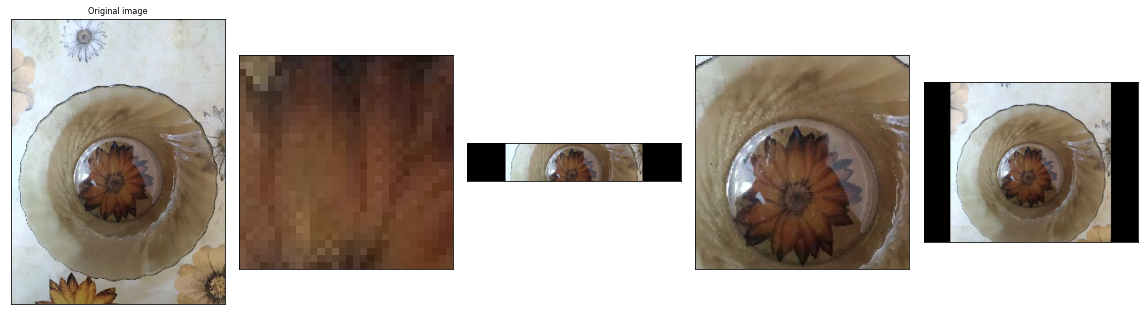

In [8]:
# CenterCrop
# The CenterCrop transform (see also center_crop()) crops the given image at the center.
# (sequence or int) – (height, width) of the crop box. If int or sequence with single int, it is used for both directions.
# Особенность: если кроп больше исходного изображения, пустоты заполняются "паддингами"

center_crops = [T.CenterCrop(size=size)(orig_img) for size in (30, (70, 400), 150, orig_img.size)]
plot(center_crops)
print(orig_img.size)
[img.size for img in center_crops]

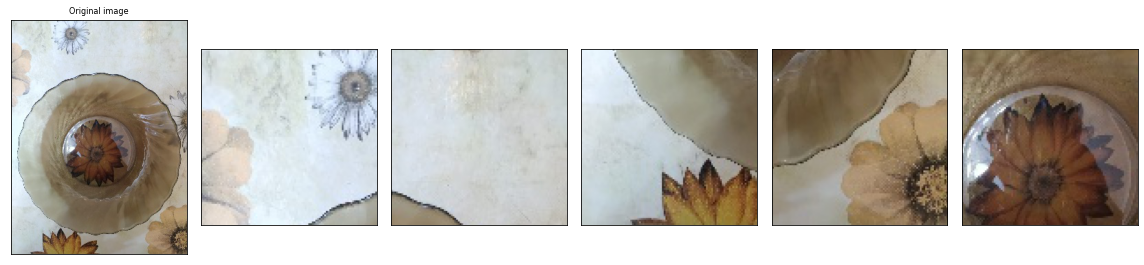

In [9]:
# FiveCrop
# The FiveCrop transform (see also five_crop()) crops the given image into four corners and the central crop.
# Возвращает 5 кропов указанного размера из исходного изображения, вырезанные с 4-х углов и центра

(top_left, top_right, bottom_left, bottom_right, center) = T.FiveCrop(size=(100, 100))(orig_img)
plot([top_left, top_right, bottom_left, bottom_right, center])

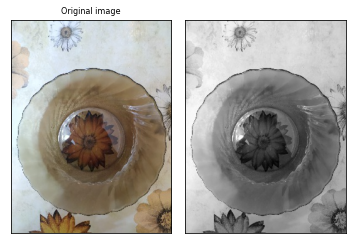

In [10]:
# Grayscale
# The Grayscale transform (see also to_grayscale()) converts an image to grayscale
tmp_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [5, 5]

gray_img = T.Grayscale()(orig_img)
plot([gray_img], cmap='gray')

plt.rcParams["figure.figsize"] = tmp_figsize

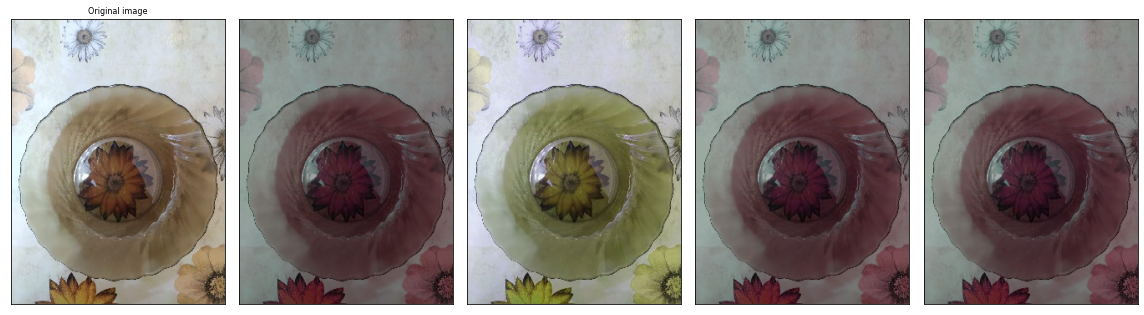

In [11]:
# ColorJitter
# The ColorJitter transform randomly changes the brightness, saturation, and other properties of an image.

# Parameters:
# brightness (float or tuple of python:float (min, max)) – How much to jitter brightness. brightness_factor 
#   is chosen uniformly from [max(0, 1 - brightness), 1 + brightness] or the given [min, max]. Should be non 
#   negative numbers.

# contrast (float or tuple of python:float (min, max)) – How much to jitter contrast. contrast_factor is chosen 
#   uniformly from [max(0, 1 - contrast), 1 + contrast] or the given [min, max]. Should be non negative numbers.

# saturation (float or tuple of python:float (min, max)) – How much to jitter saturation. saturation_factor is 
#   chosen uniformly from [max(0, 1 - saturation), 1 + saturation] or the given [min, max]. Should be non 
#   negative numbers.

# hue (float or tuple of python:float (min, max)) – How much to jitter hue. hue_factor is chosen uniformly 
#   from [-hue, hue] or the given [min, max]. Should have 0<= hue <= 0.5 or -0.5 <= min <= max <= 0.5.

jitter = T.ColorJitter(brightness=.5, hue=.3)
jitted_imgs = [jitter(orig_img) for _ in range(4)]
plot(jitted_imgs)

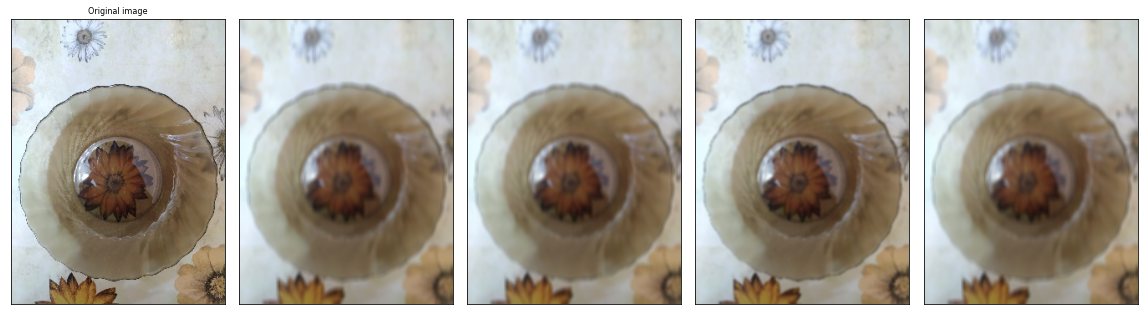

In [13]:
# GaussianBlur
# The GaussianBlur transform (see also gaussian_blur()) performs gaussian blur transform on an image.
# Размытие по Гауссу

# появилось с версии 1.7
# не понял зачем в примере используется цикл, т.к. все 4 примера вызываются с конкретно заданными 
# параметрами, дающими идентичный результат (насколько я понял из документации)

blurrer = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
blurred_imgs = [blurrer(orig_img) for _ in range(4)]
plot(blurred_imgs)

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ../aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]


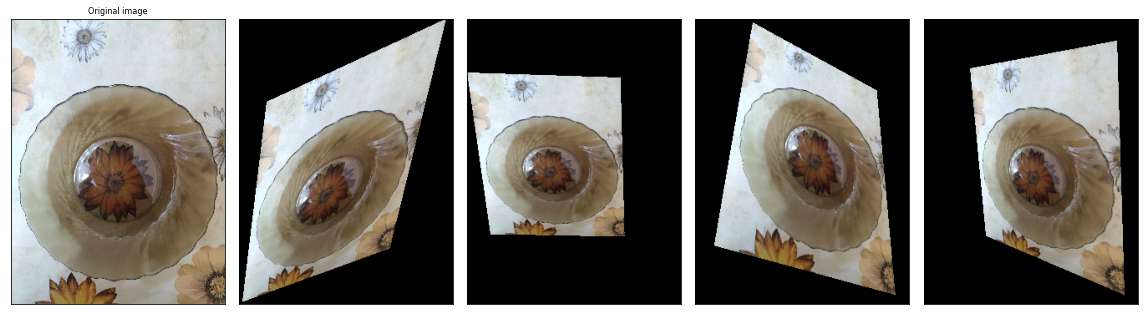

In [14]:
# RandomPerspective
# The RandomPerspective transform (see also perspective()) performs random perspective transform on an image.

perspective_transformer = T.RandomPerspective(distortion_scale=0.6, p=1.0)
perspective_imgs = [perspective_transformer(orig_img) for _ in range(4)]
plot(perspective_imgs)

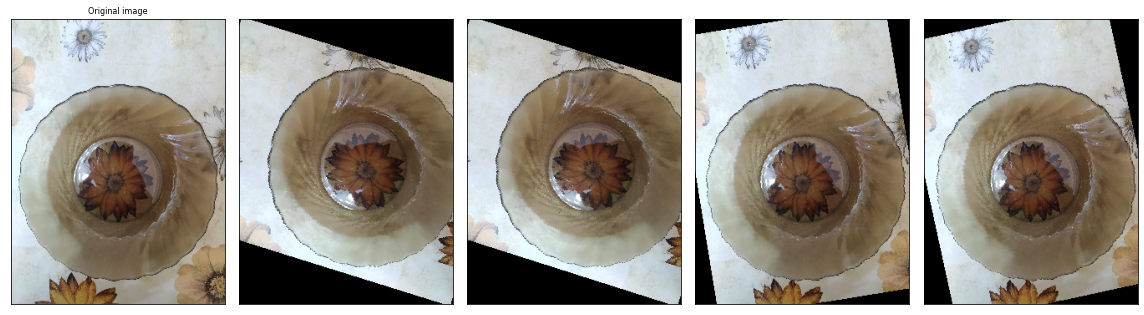

In [15]:
# RandomRotation
# The RandomRotation transform (see also rotate()) rotates an image with random angle.

rotater = T.RandomRotation(degrees=(0, 180))
rotated_imgs = [rotater(orig_img) for _ in range(4)]
plot(rotated_imgs)

(256, 341)


[(256, 341), (256, 341), (256, 341), (256, 341)]

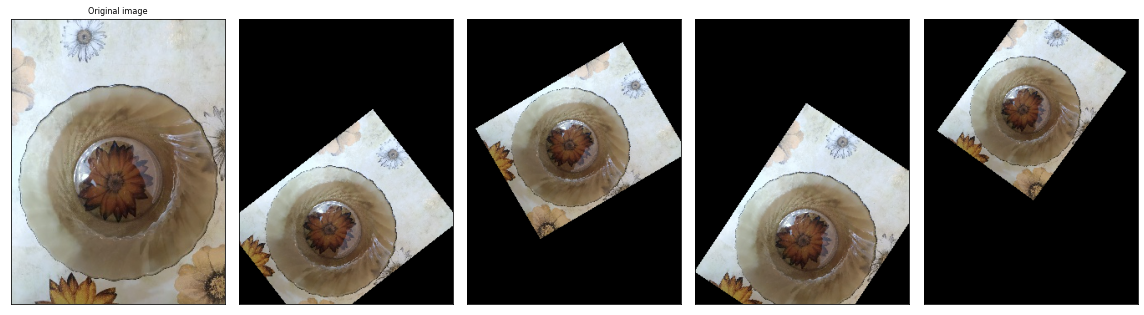

In [17]:
# RandomAffine
# The RandomAffine transform (see also affine()) performs random affine transform on an image.

# Аффнное преобразование, иногда афинное преобразование[1] (от лат. affinis «соприкасающийся, 
# близкий, смежный») — отображение плоскости или пространства в себя, при котором параллельные 
# прямые переходят в параллельные прямые, пересекающиеся — в пересекающиеся, скрещивающиеся — 
# в скрещивающиеся[2].

affine_transfomer = T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))
affine_imgs = [affine_transfomer(orig_img) for _ in range(4)]
plot(affine_imgs)

print(orig_img.size)
[img.size for img in affine_imgs]

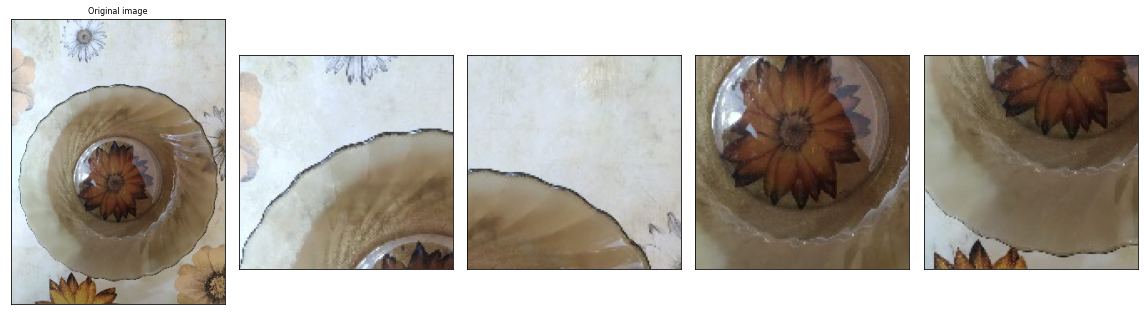

In [18]:
# RandomCrop
# The RandomCrop transform (see also crop()) crops an image at a random location.

cropper = T.RandomCrop(size=(128, 128))
crops = [cropper(orig_img) for _ in range(4)]
plot(crops)

(256, 341)


[(128, 128), (128, 128), (128, 128), (128, 128)]

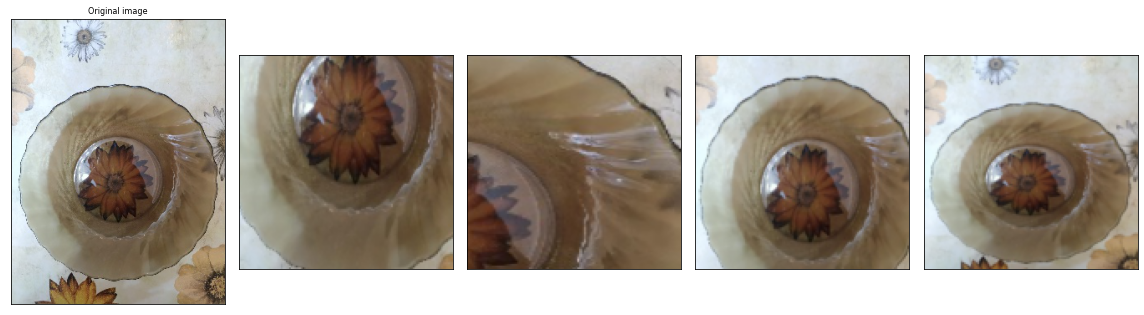

In [57]:
# RandomResizedCrop
# The RandomResizedCrop transform (see also resized_crop()) crops an image at a random location, 
# and then resizes the crop to a given size.

# A crop of the original image is made: the crop has a random area and a random aspect ratio. 
# This crop is finally resized to the given size. This is popularly used to train the Inception networks.

# Что делает: 
# 1) из исходного изображения берется абсолютно рандомный кроп, с любым соотношением и размером сторон 
#    (т.е. размера (randint(h_orig), randint(w_orig))
# 2) производится его ресайс (с растягиванием/сжатием) в заданный размер

# Т.е. по итогу абсолютно получается рандомно вырезанный, сжатый/растянутый кусок исходного изображения, 
# на выходе заданного размера 

#Обратить внимание на отличия от RandomCrop!

# Есть пометка, что это популярное преобразование для обучения сетей, но скорей всего тут необходимо уточнение, 
# что полезно для обучания сети на рандомных объектах из исходного изображения, если исходное изображение содержит 
# их несколько/много. Для случая, когда у нас имеется один объект почти на все изображение, применение этого
# преобразования на мой взгляд "погранично".

resize_cropper = T.RandomResizedCrop(size=(128, 128))
resized_crops = [resize_cropper(orig_img) for _ in range(4)]
plot(resized_crops)

print(orig_img.size)
[img.size for img in resized_crops]

(256, 341)


[(224, 224), (224, 224), (224, 224), (224, 224)]

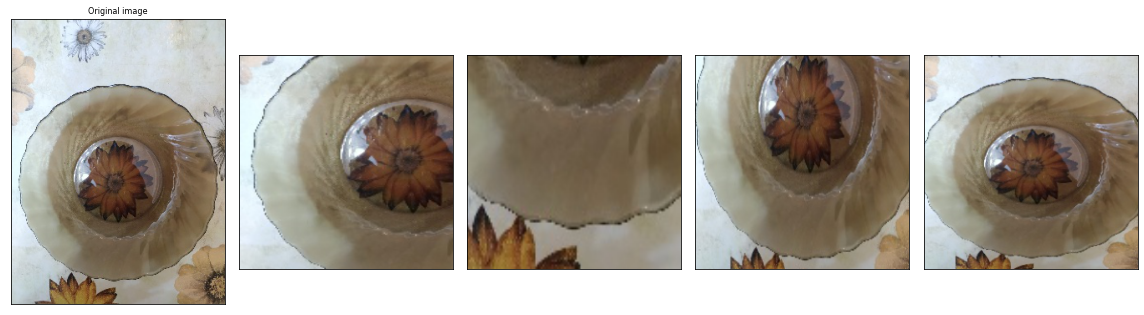

In [60]:
resize_cropper = T.RandomResizedCrop(224)
resized_crops = [resize_cropper(orig_img) for _ in range(4)]
plot(resized_crops)

print(orig_img.size)
[img.size for img in resized_crops]

(256, 341)


[(50, 50), (50, 50), (50, 50), (50, 50)]

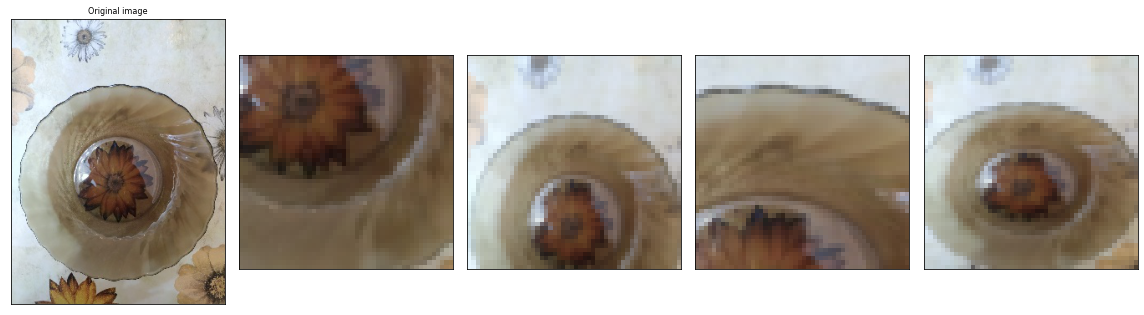

In [68]:
resize_cropper = T.RandomResizedCrop(50)
resized_crops = [resize_cropper(orig_img) for _ in range(4)]
plot(resized_crops)

print(orig_img.size)
[img.size for img in resized_crops]

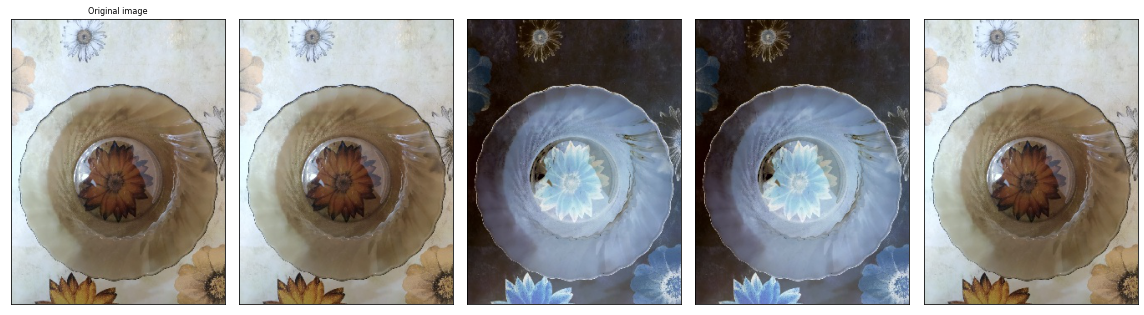

In [36]:
# RandomInvert
# The RandomInvert transform (see also invert()) randomly inverts the colors of the given image.

inverter = T.RandomInvert()
invertered_imgs = [inverter(orig_img) for _ in range(4)]
plot(invertered_imgs)

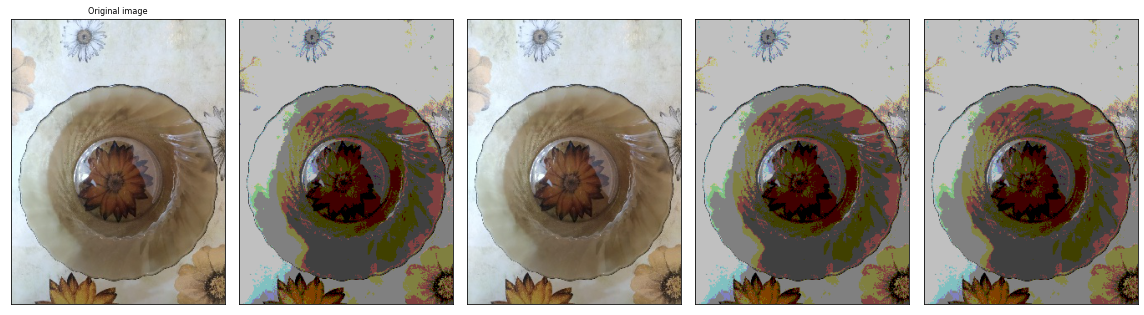

In [37]:
# RandomPosterize
# The RandomPosterize transform (see also posterize()) randomly posterizes the image by reducing 
# the number of bits of each color channel.

posterizer = T.RandomPosterize(bits=2)
posterized_imgs = [posterizer(orig_img) for _ in range(4)]
plot(posterized_imgs)

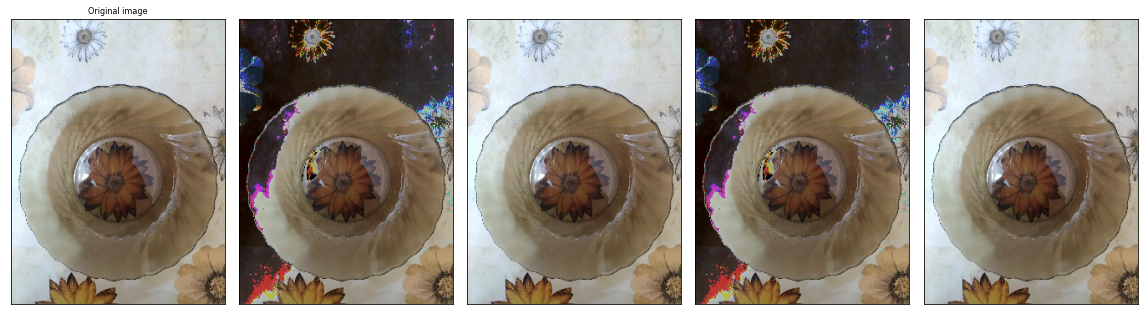

In [38]:
# RandomSolarize
# The RandomSolarize transform (see also solarize()) randomly solarizes the image by 
# inverting all pixel values above the threshold.

solarizer = T.RandomSolarize(threshold=192.0)
solarized_imgs = [solarizer(orig_img) for _ in range(4)]
plot(solarized_imgs)

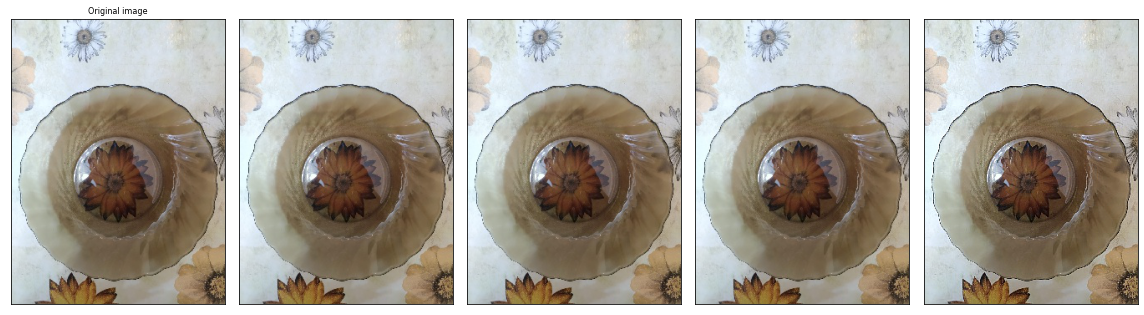

In [39]:
# RandomAdjustSharpness
# The RandomAdjustSharpness transform (see also adjust_sharpness()) randomly adjusts the 
# sharpness of the given image.

sharpness_adjuster = T.RandomAdjustSharpness(sharpness_factor=2)
sharpened_imgs = [sharpness_adjuster(orig_img) for _ in range(4)]
plot(sharpened_imgs)

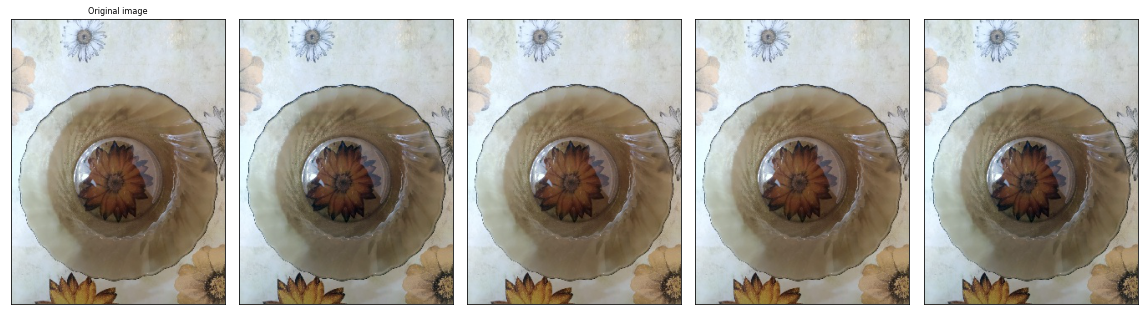

In [40]:
# RandomAutocontrast
# The RandomAutocontrast transform (see also autocontrast()) randomly applies autocontrast to the given image.

autocontraster = T.RandomAutocontrast()
autocontrasted_imgs = [autocontraster(orig_img) for _ in range(4)]
plot(autocontrasted_imgs)

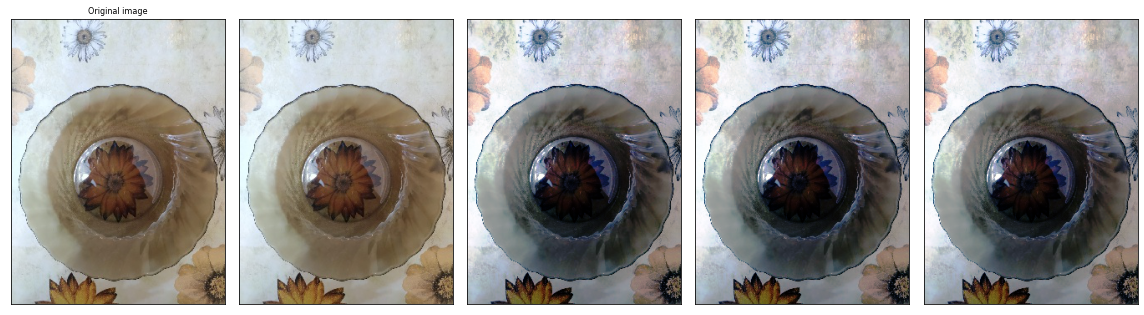

In [41]:
# RandomEqualize
# The RandomEqualize transform (see also equalize()) randomly equalizes the histogram of the given image.

equalizer = T.RandomEqualize()
equalized_imgs = [equalizer(orig_img) for _ in range(4)]
plot(equalized_imgs)

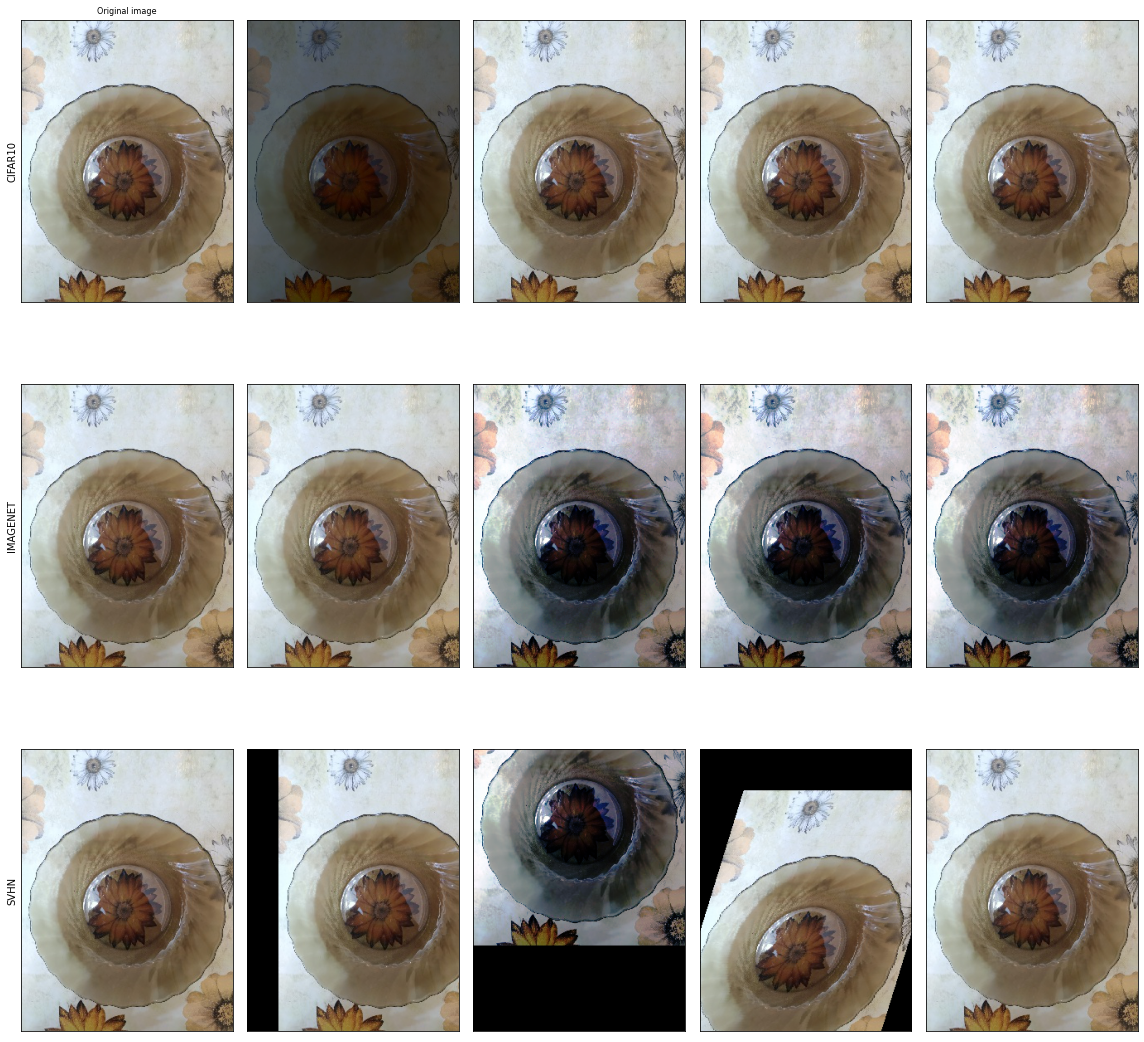

In [45]:
# AutoAugment
# The AutoAugment transform automatically augments data based on a given auto-augmentation policy. 
# See AutoAugmentPolicy for the available policies.

policies = [T.AutoAugmentPolicy.CIFAR10, T.AutoAugmentPolicy.IMAGENET, T.AutoAugmentPolicy.SVHN]
augmenters = [T.AutoAugment(policy) for policy in policies]
imgs = [
    [augmenter(orig_img) for _ in range(4)]
    for augmenter in augmenters
]
row_title = [str(policy).split('.')[-1] for policy in policies]
plot(imgs, row_title=row_title)

In [46]:
# RandAugment
# The RandAugment transform automatically augments the data.

augmenter = T.RandAugment()
imgs = [augmenter(orig_img) for _ in range(4)]
plot(imgs)

AttributeError: module 'torchvision.transforms' has no attribute 'RandAugment'

In [44]:
# TrivialAugmentWide
# The TrivialAugmentWide transform automatically augments the data.

augmenter = T.TrivialAugmentWide()
imgs = [augmenter(orig_img) for _ in range(4)]
plot(imgs)

AttributeError: module 'torchvision.transforms' has no attribute 'TrivialAugmentWide'

**Randomly-applied transforms**

Some transforms are randomly-applied given a probability p. That is, the transformed image may actually be the same as the original one, even when called with the same transformer instance!

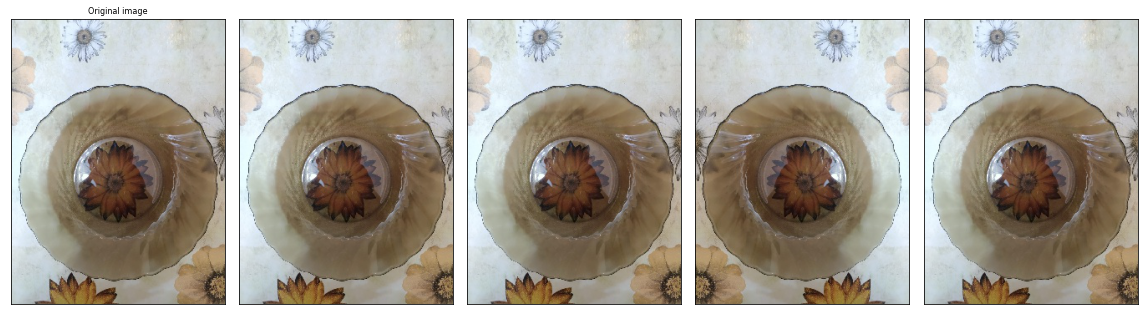

In [47]:
# RandomHorizontalFlip
# The RandomHorizontalFlip transform (see also hflip()) performs horizontal flip of an image, with a given probability.

hflipper = T.RandomHorizontalFlip(p=0.5)
transformed_imgs = [hflipper(orig_img) for _ in range(4)]
plot(transformed_imgs)

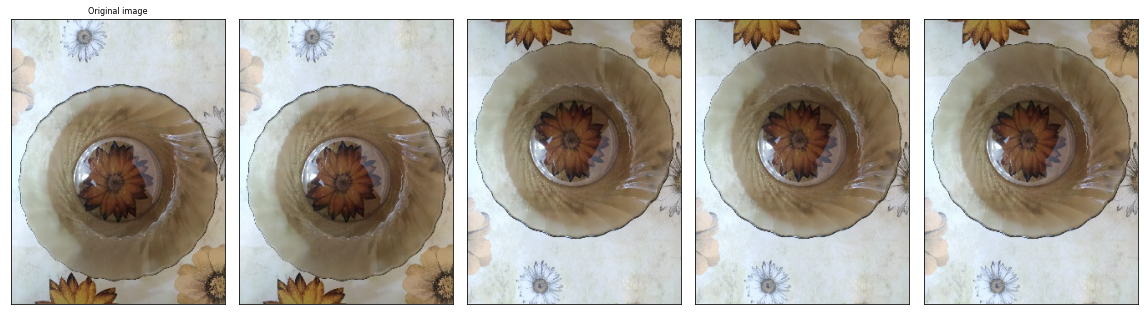

In [48]:
# RandomVerticalFlip
# The RandomVerticalFlip transform (see also vflip()) performs vertical flip of an image, with a given probability.

vflipper = T.RandomVerticalFlip(p=0.5)
transformed_imgs = [vflipper(orig_img) for _ in range(4)]
plot(transformed_imgs)

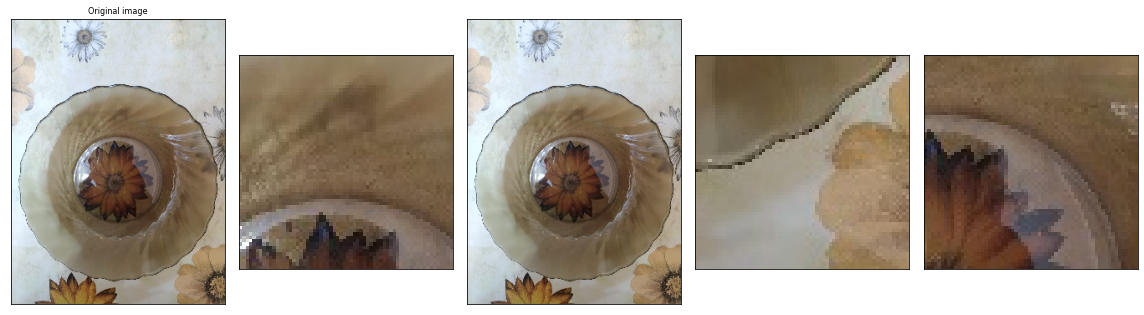

In [52]:
# RandomApply
# The RandomApply transform randomly applies a list of transforms, with a given probability.

applier = T.RandomApply(transforms=[T.RandomCrop(size=(64, 64))], p=0.5)
transformed_imgs = [applier(orig_img) for _ in range(4)]
plot(transformed_imgs)

In [4]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['test', '.DS_Store', 'train']


In [ ]:
!ls train

In [ ]:
!rm -rf train val test